Algunos de estos ejercicios se pueden hacer tanto en `Python` como en el `Neo4j Browser`. Cada apartado indicará si se deben hacer obligatoriamente en Python, o si podéis utilizar cualquiera de las alternativas indistintamente. En ambos casos, os debéis asegurar que se respeta el esquema (renombrando propiedades si es necesario).

La idea es que los hagáis en Python directamente, pero también es recomendable que os familiaricéis con la otra herramienta para poder hacer operaciones en la base de datos de forma rápida y sencilla. 

Para devolver los resultados como diccionarios, tendréis que hacer `dict(record)`, donde `record` es un elemento de la lista de `records` devuelva por la consulta.

En las funciones de Python en las que se modifique el grafo, se debe devolver un diccionario con el resumen de la ejecución (`Dict[str, Any]`). Este diccionario se puede devolver accediendo al atributo _counters_ del resumen de la ejecución de la consulta (segundo parámetro que devuelve `execute_query`).

# 1. Investigación Criminal (POLE)

Desde la Interpol, nos han contratado para detectar comportamientos criminales utilizando su base de datos de Manchester (convertirnos en Sherlock Holmes, vaya). Esta base de datos sigue el esquema **POLE**: **P**ersonas, **O**bjetos, **L**ocalizaciones y **E**ventos. El modelo de datos que tenemos es el siguiente:

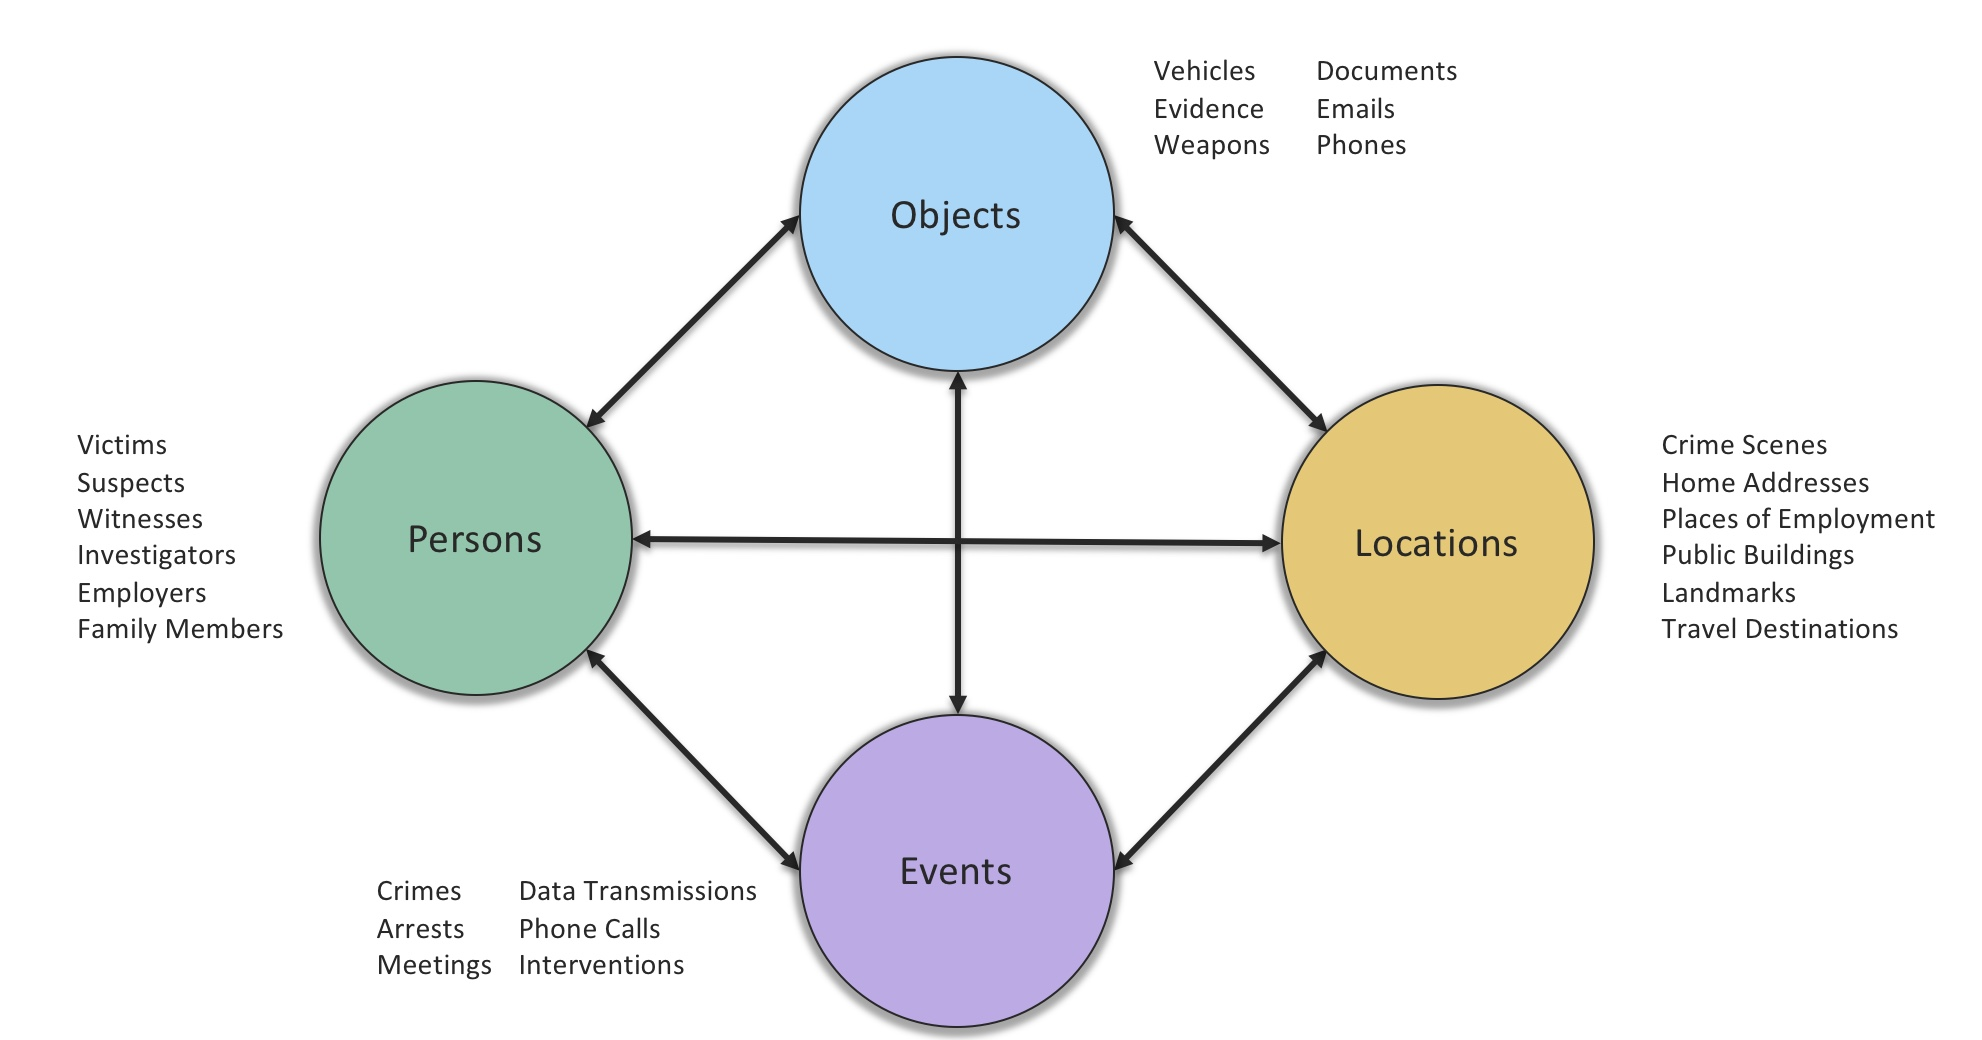

Vamos a crear una clase en Python **GestionInvestigacion** que implemente distintos métodos que nos ayuden a analizar esta base de datos para que, con suerte, podamos ayudar a capturar criminales:

## 1.1 Consultas Varias

### Consulta 1.1.1 (Python / Neo4j Browser)

Devuelve la dirección de las 10 localizaciones (_Location_) en que se han cometido más crímenes (relación _OCCURRED\_AT_).

Esquema: (**direccion**, **num_crimenes**).

### Consulta 1.1.2 (Python)

Devuelve cuántos crímenes se han cometido de cada tipo (propiedad _type_ de los nodos con la etiqueta _Crime_). En lugar de devolver la solución como una lista de diccionarios, devuelve un único diccionario que tiene como claves los distintos tipos, y como valores el número de crímenes cometidos de ese tipo. A los crímenes sin tipo, le asignamos el nombre `Sin tipo` en la solución. Podéis utilizar la función `coalesce()`, que funciona de forma similar a su equivalente en SQL.

```python
def consulta_1_1_2(self) -> Dict[str, int]:
```

### Consulta 1.1.3 (Python)

Dado el apellido de un inspector (campo _surname_ de un nodo con etiqueta _Officer_), devuelve los crímenes que ha investigado (relación _INVESTIGATED\_BY_).

Esquema: (**id_crimen**, **tipo_crimen**, **progreso**). El campo **progreso** se refiere a _last\_outcome_.

```python
def crimenes_investigados_inspector(self,apellido: str) -> List[Dict[str, str]]:
```

Puedes probar la consulta con el apellido `"Larive"`.

### Consulta 1.1.4 (Python) (DIFÍCIL)

Dado el id de un crimen, devuelve la lista de personas a las que un sospechoso (relación _PARTY_TO_) ha llamado más de una vez, considerando únicamente las llamadas que hayan durado más de 30 minutos. Investiga en la base de datos cómo recuperar la información de las llamadas.

```python
def personas_llamadas_sospechosas(self, id_crimen: str) -> List[Dict[str, Any]]:
```

Esquema: (**nombre_sospechoso**, **apellido_sospechoso**, **nombre_llamada**, **apellido_llamada**, **num_llamadas**). **num_llamadas** se refiere al número de llamadas que superan 30 minutos.


Prueba con el id del crimen `"34f16237cac32a82724094222dd3b92bfe9f415864638071e144154d078d0af8"`.

## 1.2 Investigación Criminal (Python)

Vamos a ayudar al inspector **Devy Larive**, con número de placa **26-5234182**, con alguno de los crímenes relacionados con drogas que está investigando. 

### 1.2.1 Determinar Crímenes con Drogas

En primer lugar, vamos a determinar cuáles son estos crímenes, Para ello, filtraremos aquellos crímenes relacionados con drogas (propiedad _type_ con valor `'Drugs'`) que están siendo investigados actualmente por el inspector (relación _INVESTIGATED_BY_). Para determinar qué crímenes están siendo investigados, filtramos aquellos que tienen la propiedad _last_outcome_ con valor `'Under investigation'` en el crimen correspondiente. 

Para que la consulta nos pueda servir para otros inspectores y tipos de crímenes, se pasarán como parámetros el número de placa del director y el tipo de delito:

```python
def lista_crimenes(self, num_placa: str, delito: str) -> List[str]:
```

### 1.2.2 Determinar Sospechosos

Una vez tenemos la lista de crímenes del inspector, vamos a investigar quiénes son los sospechosos de los crímenes anteriores. Como ya tenemos la lista de ids de los crímenes sobre los que queremos consultar, vamos a crear una función que, dada una lista de ids, nos devuelva la información sobre las personas que han participado en esos crímenes (relación _PARTY_TO_).

Los datos se van a devolver como un diccionario, tal que dado el id de un crimen, devuelva una lista con la información de cada sospechoso. Esta información sigue el esquema: (**id**, **nombre**, **apellido**). El **id** se refiere al campo _nhs_no_.

**NOTA**: dentro de `collect()`, se pueden renombrar los campos con la notación de diccionario. Por ejemplo: `collect({nombre: p.name})`.

```python
def sospechosos_crimenes(self, ids_crimen: List[str]) -> Dict[str, List[Dict[str, Any]]]
```

### 1.2.3 Lista de Pruebas y Localizaciones

Otra parte importante de la investigación es determinar la localización del delito y las pruebas del mismo. Un delito está conectado con una localización a través de la relación _OCCURRED_AT_, y una prueba conecta con un delito a través de la relación _INVOLVED_IN_, teniendo además de tipo `'Evidence'`.

Para facilitar este proceso, vamos a implementar una función que, dados los ids de los delitos, devuelva un diccionario con la localización y la lista de pruebas. Este diccionario tiene como clave el id del delito correspondiente, y como valor un diccionario con dos campos: `localizacion` tiene la dirección del delito (propiedad `address` del nodo correspondiente); y `pruebas` contiene una lista con las descripciones de la pruebas involucradas. 

```python
def informacion_delito(self, ids_crimen: List[str]) -> Dict[str, Dict[str, Any]]
```

Por ejemplo, para los delitos de drogas que está investigando el inspector, debería devolver el siguiente diccionario:

```sh
{'2dec74f10fd12d8dcb28cb05ff058b4e4134ecb58d0e515c888f0611ca794339': 
    {'localizacion': '151 Mottram Street', 
    'pruebas': ['43 Cannabis Plants, 3kg Prepared Cannabis', '£3,500 currency']},
 'b61be51a27d699f46b6dc7c3ac594783101f5e728f9cf6df898e44fc48021942': 
     {'localizacion': '23 Bodmin Road', 
     'pruebas': ['120g Packaged Cannabis', '£550 currency']},
 '34f16237cac32a82724094222dd3b92bfe9f415864638071e144154d078d0af8': 
     {'localizacion': '23 Bodmin Road', 
     'pruebas': ['£830 currency', '250g Loose Cannabis', 'Electronic Scale']}}```

### 1.2.4 Conexión Sospechosos (DIFICIL)

Una vez hemos recopilado más información sobre los sospechosos, queremos averiguar si hay algún tipo de relación entre ellos. Para ello, vamos a implementar una función que, dada una lista de sospechosos (identificados por su **id**), devuelva todas las conexiones entre los mismos, usando **todos** los caminos más cortos. Esto quiere decir que por cada par de sospechosos en la lista, se deben construir todos los caminos más cortos que los conecten. Para que la consulta no sea demasiado costosa, solo vamos a considerar caminos de longitud máxima 3. Además, para evitar repeticiones en el resultado, comprobad que `id_p1 < id_p2`, donde `id_p1` y `id_p2` son los ids de dos sospechosos.

Los sospechosos pueden estar conectados por las siguientes relaciones: _KNOWS_, _KNOWS_LW_ (vive con esa persona), _KNOWS_SN_ (conoce por relaciones sociales), _FAMILY_REL_ (son familia), _KNOWS_PHONE_ (conoce el tlf). El formato de salida de la función es un diccionario que, dada la tupla de ids de dos sospechosos ordenados por su id, devuelva una lista con las conexiones. Estas conexiones contienen la siguiente información: (**id**, **nombre**, **apellido**) de cada una de estas personas. Además, se deben devolver resultados sin repeticiones.

```python
def conexiones_sospechosos(self, sospechosos: List[str]) -> Dict[Tuple[str, str], List[List[str]]]:
```

Se muestra un ejemplo de su ejecución, para los ids `['879-22-8665', '249-54-6589', '455-19-0708']`. Si os sale un mensaje de warning de `{code: Neo.ClientNotification.Statement.AggregationSkippedNull}`, ignoradlo.

```sh
{('249-54-6589', '455-19-0708'): [[{'apellido': 'Powell', 'id': '249-54-6589','nombre': 'Jack'},
                                   {'apellido': 'Morales','id': '335-71-7747','nombre': 'Brian'},
                                   {'apellido': 'Peterson','id': '434-76-7869','nombre': 'Kelly'},
                                   {'apellido': 'Robertson','id': '455-19-0708','nombre': 'Amanda'}]],
 ('249-54-6589', '879-22-8665'): [[{'apellido': 'Powell','id': '249-54-6589','nombre': 'Jack'},
                                   {'apellido': 'Morales','id': '335-71-7747', 'nombre': 'Brian'},
                                   {'apellido': 'Williamson','id': '337-28-4424','nombre': 'Phillip'},
                                   {'apellido': 'Walker','id': '879-22-8665','nombre': 'Raymond'}],
                                  [{'apellido': 'Powell','id': '249-54-6589','nombre': 'Jack'},
                                   {'apellido': 'Ward', 'id': '881-20-2396', 'nombre': 'Alan'},
                                   {'apellido': 'Williamson','id': '337-28-4424', 'nombre': 'Phillip'},
                                   {'apellido': 'Walker', 'id': '879-22-8665','nombre': 'Raymond'}],
                                  [{'apellido': 'Powell', 'id': '249-54-6589','nombre': 'Jack'},
                                   {'apellido': 'Ward', 'id': '881-20-2396','nombre': 'Alan'},
                                   {'apellido': 'Peters','id': '250-75-5238', 'nombre': 'Kathleen'},
                                   {'apellido': 'Walker', 'id': '879-22-8665','nombre': 'Raymond'}]],
 ('455-19-0708', '879-22-8665'): []}
 ```


## 1.3 Personas Vulnerables (Python / Neo4j Browser)

En este ejercicio, vamos a determinar el índice de vulnerabilidad de personas que viven en entornos criminales, pero no han cometido directamente un crimen. Para ello, vamos a desglosar en distintos pasos el cómputo de este índice:

### 1.3.1 Consulta Inicial

Una persona es vulnerable si conoce a múltiples personas (con la relación _KNOWS_) que están relacionadas con crímenes (relación _PARTY\_TO_) mientras ellos no están relacionados con ningún crimen. Devuelve las 10 personas más vulnerables en el grafo; es decir, que estén relacionadas con un número mayor de personas relacionadas con crímenes. 

**NOTA**: ten en cuenta que una persona puede estar relacionadas con múltiples crímenes y no las queremos contar varias veces. Utilizad `count(distinct ...))` para llevarlo a cabo.

Esquema: (**id**, **nombre**, **apellido**, **num_criminales**). El **id** se refiere al campo _nhs_no_.

### 1.3.2 Extendiendo la Definición

Vamos a realizar la misma consulta anterior, pero extendiendo la definición de persona vulnerable: ahora una persona también es vulnerable si conoce a una persona que a su vez conoce a otra persona que sí ha cometido un crimen.

Esquema: (**id**, **nombre**, **apellido**, **num_criminales**)

### 1.3.3 Determinando el Índice

La consulta anterior ha servido para determinar con cuántos criminales está relacionado una persona vulnerable. El índice de vulnerabilidad se determina haciendo el cociente entre el número obtenido en la consulta anterior y el número total de personas que una persona conoce, o que son amigos de sus amigos (independientemente de si han cometido un crimen o no). Si una persona ha cometido un crimen, entonces su índice de vulnerabilidad también es 0. Repite la consulta anterior para que devuelva el índice de vulnerabilidad de las 10 personas con mayor índice. Hay que asegurarse que todas las personas de nuestra base de datos incluyen el índice de vulnerabilidad. Si una persona no conoce a nadie en nuestra base de datos, su índice de vulnerabilidad es 0.

**NOTA**: a la hora de hacer la división entre el número de criminales y el número de conocidos, es necesario castear a float con la función `toFloat()` ambos operandos. De lo contrario, se realiza la división entera.

Esquema: (**id**, **nombre**, **apellido**, **indice_vulnerabilidad**)

### 1.3.4 Almacenando Índice de Vulnerabilidad

Por último, vamos a modificar la consulta anterior para almacenar el índice de vulnerabilidad de cada persona en lugar de devolverlo como resultado. Para ello, guardaremos la nueva propiedad _indice\_vulnerabilidad_ dentro de cada nodo persona. 

# 2 Grafo Social de Bluesky

Vamos a crear nuestra propia base de datos que modele esta red social, utilizando una muestra representativa de las cuentas que siguen y son seguidas por la cuenta oficial de la UCM: `@ucm.es`. El modelo de datos es muy sencillo, así que podéis explorarlo vosotros mismo en el _browser_.

Estos datos son **reales** (descargados con la API de `Bluesky`, ya que la de `Twitter` está restringida...), así que en este ejercicio podréis comprobar la utilidad de lo que aprendemos en clase.

## 2.1 Gestionar Nuestro Propio Perfil

Los profesores de la asignatura de **ABD** están planeando abrir una cuenta en la red social `Bluesky`: `@ABDucidos`, en el que planeamos ir mostrando las distintas actividades que se realizan en esta asignatura. Para ello, vamos a realizar una serie de consultas y modificaciones sobre el grafo, para así determinar cuáles son las mejores acciones para promocionar nuestro perfil.

### 2.1.1 Crear Perfil (Python/Neo4j)

Crea un nuevo perfil con la información de la cuenta:

1. Etiqueta: la etiqueta es `:Cuenta`.
1. Propiedades:
    * cuenta: `ABDucidos.bsky.social`.
    * nombre: `Ampliación de Bases de Datos`
    * bio: `Bases de Datos Relacionales, No SQL... ¡Tenemos de todo!`
    * num_followers: 0
    * num_following: 0
    * num_posts: 0

Además, introduce un post que grite a los cuatro vientos: `¡Hola mundo!`. Indaga sobre el formato de los posts, y actualiza `num_posts` para la cuenta correspondiente.

### 2.1.2 Seguir a Perfiles Afines (Python / Neo4j)

Nuestra primera idea es determinar qué perfiles pueden ser afines a nuestra cuenta, para empezar a seguirlos. Un perfil es afín si lo sigue la cuenta `ucm.es`, o si tiene en su biografía alguna de las siguientes palabras claves: `PhD`, `Profesor` ó `Universidad` (independientemente de mayúsculas y minúsculas). Actualiza el grafo para que nuestra cuenta de `ABDucidos` empiece a seguir a estas cuentas, actualizando los contadores del número de seguidores y de seguidos de cada una de las cuentas involucradas.

### 2.1.3 Seguidores (Python)

¡Nuestros esfuerzos han tenido sus frutos! Algunas de estas cuentas nos han seguido de vuelta. Crea una función, `seguir_cuenta`, que dada dos cuentas, actualice el grafo para que la primera cuenta empiece a seguir a la otra con la relación _:FOLLOWS_. Además, se deben actualizar el número de seguidores y cuentas seguidas de cada una de las cuentas involucradas.

```python
def seguir_cuenta(self, cuenta1: str, cuenta2: str) -> Dict[str, Any]:
```

Utilizando esta función, actualiza las cuentas que siguen a `ABDucidos` con el siguiente listado:

```python
cuentas = ["ucm.es", "uji.es", "csic.es", "xataka.bsky.social", "uib.cat"]
```

## 2.2 Labores de Moderación

Desde la cuenta de `ABDucidos`, vamos a llevar a cabo ciertas labores de moderación, para restringir el uso de la misma. Vamos a utilizar dos nuevas etiquetas: `:CuentaSuspendida` y `:PostOfensivo`, para marcar qué cuentas se encuentran suspendidas y que posts rompen las normas del sitio web. 

### 2.2.1 Marcar Post Ofensivos (Python / Neo4j)

Vamos a reemplazar la etiqueta `:Post` por `:PostOfensivo` en aquellos posts que incluyan el siguiente vocabulario, independientemente de mayúsculas y minúsculas: `gilipoll`, `subnormal`, `twitter` (no nos gusta la competencia) y `asshole`. Además, para las cuentas que han escrito un post ofensivo, vamos a añadir la propiedad _num_posts_ofensivos_ con el número de post ofensivos.

**NOTA**: puede que te sea útil utilizar la función `coalesce()`, que devuelve el primer valor no nulo que se le pasa como argumento.

### 2.2.2 Suspender Cuentas (Python)

Vamos a suspender aquellas cuentas que tienen al menos dos post ofensivos. Implementa una función en Python que detecte aquellas cuentas que deban ser suspendidas, si no lo estaban suspendidas antes. Estas cuentas pasan a incluir la etiqueta `:CuentaSuspendida` (además de `:Cuenta`) y deben incluir una nueva propiedad: _fecha_desbaneo_. Esta fecha se computa sumando un mes a la fecha del último post ofensivo que ha escrito el usuario.

```python
def suspender_cuentas(self) -> Dict[str, Any]:
```

### 2.2.3 Desbloquear Cuentas Bloqueadas (Python)

Por último, vamos a crear una función para desbloquear aquellas cuentas que ya han cumplido el tiempo de penalización completo. Para ello, se eliminará la etiqueta `:CuentaSuspendida`, el contador de posts ofensivos de esas cuenta y la fecha de desbaneo, de tal manera que se pueda banear a los usuarios si vuelven a incumplir las normas del sitio. 

```python
def desbloquer_cuentas(self) -> Dict[str, Any]:
```

## 2.3 Consultas Varias

Por último, vamos a implementar una serie de consultas:

### 2.3.1 Cuentas con Terminación (Python)

Las cuentas de `Bluesky` pueden tener distintas terminaciones (último fragmento del nombre separado por puntos). Dada una terminación, devuelve cuántas cuentas tienen esa terminación:

```python
def num_cuentas_con_terminacion(self, terminacion: str) -> int:
```

Prueba con `.es`.

### 2.3.2 Tasa de _Followback_ (Python)

La tasa de _followback_ se computa como el cociente entre el número de cuentas que sigue un usuario (denominador) y cuántas de esas cuentas le siguen también (numerador). Implementa una función que, dada una cuenta, compute su tasa de _followback_ con respecto nuestra muestra. Por tanto, en esta función, no se puede utilizar la propiedad `num_followers`, ya que esta número considera todos los seguidores en Bluesky.

**NOTA**: Recuerda utilizar la función `toFloat` para que la división sea decimal y no entera.

```python
def tasa_followback(self, cuenta: str) -> float:
```

### 2.3.3 Media de Posts de los Usuarios Más Activos (Python)

Computa el número medio de posts de los usuarios más activos comprendidos entre los índices `i` y `j`, de acuerdo con el número de posts totales.

```python
def media_posts_usuarios_mas_activos(self, i: int, j: int) -> float:
```